# 2D to 3D Lifting Network

## Imports and Setup

In [1]:
import os

import numpy as np
import pandas as pd
from skimage import io, transform
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
plt.ion()   # interactive mode

In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def set_axes_equal(ax):
    # workaround, as matplotlib's 3D plot has no option for equisised axes (10/2021)
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


In [3]:
class BugDataset(Dataset):
    """Bug dataset."""

    def __init__(self, df, root_dir, transform=None):
        """
        Args:
            hdf_file (string): Path to the hdf file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.bugs_frame = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.bugs_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.bugs_frame.iloc[idx, 0])
        image = io.imread(img_name)
        df_columns = self.bugs_frame.columns.values.tolist()
        sample = {'image':image}
 
        for x in range(len(df_columns)):    
            sample[df_columns[x]] = self.bugs_frame.iloc[idx,x]

        if self.transform:
            sample = self.transform(sample)

        return sample
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image = sample['image']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        sample_keys = list(sample.keys())
        sample_data = list(sample.values())

        dic ={'image': torch.from_numpy(image)}
        dic[sample_keys[1]] = sample_data[1]
        for x in range(2,len(sample_keys)):
            dic[sample_keys[x]] = torch.FloatTensor(sample_data[x])
        return dic

In [4]:
target_dir = "../data/single_sungaya/"
out_df = pd.read_hdf(os.path.join(target_dir, "Data_3D_Pose.hdf5"))
new_df = pd.DataFrame()
for col, x in out_df.iterrows():
    if x['visibility'][2]==1:
        new_df = new_df.append(x)
new_df.reset_index(drop=True, inplace=True)

new_df['key_points_2D'] = new_df['key_points_2D'].apply(np.array)
new_df['key_points_3D'] = new_df['key_points_3D'].apply(np.array)

## Centralise

In [5]:
keypoint = 3
def centralise_2d(sample):
    x_diff, y_diff = sample[keypoint-1][0], sample[keypoint-1][1]
    for i in range(len(sample)):
        sample[i][0] = sample[i][0] - x_diff
        sample[i][1] = sample[i][1] - y_diff
    return sample
def centralise_3d(sample):
    x_diff, y_diff, z_diff = sample[keypoint-1][0], sample[keypoint-1][1], sample[keypoint-1][2]
    for i in range(len(sample)):
        sample[i][0] = sample[i][0] - x_diff
        sample[i][1] = sample[i][1] - y_diff
        sample[i][2] = sample[i][2] - z_diff
    return sample

In [6]:
new_df['key_points_2D'] = new_df['key_points_2D'].apply(centralise_2d)
new_df['key_points_3D'] = new_df['key_points_3D'].apply(centralise_3d)

## Normalise Dataframe

In [7]:
array_2d = np.array(new_df['key_points_2D'].to_numpy())
array_3d = np.array(new_df['key_points_3D'].to_numpy())

for x in range(len(array_2d)):
    array_2d[x] = np.array(array_2d[x])
    array_3d[x] = np.array(array_3d[x])

fixed_array_2d = np.empty((len(array_2d),124))
fixed_array_3d = np.empty((len(array_3d),186))
for x in range(len(fixed_array_2d)):
    z = array_2d[x].reshape(1,124)
    fixed_array_2d[x] = z
for x in range(len(fixed_array_3d)):
    z = array_3d[x].reshape(1,186)
    fixed_array_3d[x] = z

means_2d = np.mean(fixed_array_2d, axis=0).reshape((62,2))
means_3d = np.mean(fixed_array_3d, axis=0).reshape((62,3))
std_2d =  np.std(fixed_array_2d, axis=0).reshape((62,2))
std_3d = np.std(fixed_array_3d, axis=0).reshape((62,3))

def normal_2(x):
    return np.nan_to_num((x-means_2d)/std_2d)
def normal_3(x):
    return np.nan_to_num((x-means_3d)/std_3d)

new_df['key_points_2D'] = new_df['key_points_2D'].apply(normal_2)
new_df['key_points_3D'] = new_df['key_points_3D'].apply(normal_3)


In [8]:
sungaya_dataset = BugDataset(df=new_df,
                             root_dir=target_dir,transform=transforms.Compose([
                                ToTensor()
                                   ]))

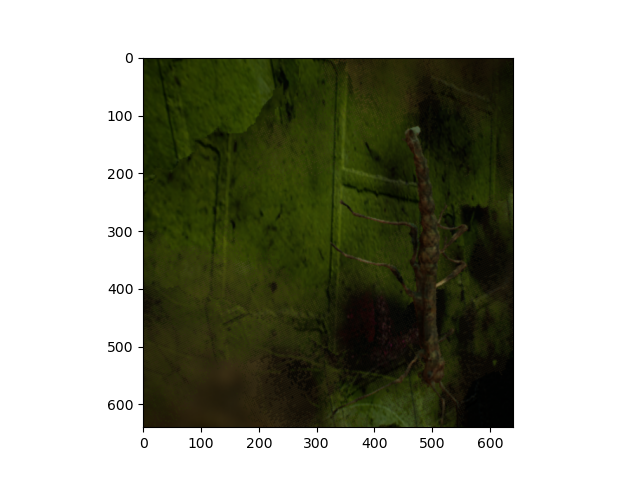

In [9]:
sample = sungaya_dataset[1]
# print(sample)
image = sample["file_name"]
plt.figure()
plt.imshow(io.imread(os.path.join(target_dir,image)))
plt.show()

In [10]:
train_split = 0.7
valid_split = 0.1
train_size = int(train_split * len(sungaya_dataset))
valid_size = int(valid_split * len(sungaya_dataset))
test_size = len(sungaya_dataset) - (train_size+valid_size)
train_dataset,valid_dataset ,test_dataset = torch.utils.data.random_split(sungaya_dataset, [train_size, valid_size, test_size], generator=torch.Generator().manual_seed(42))

In [11]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [12]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))    
class Net(nn.Module):
    
    def __init__(self,n_inputs,hidden,n_output):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.seq1 = nn.Sequential(
            nn.Linear(n_inputs, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden, n_inputs)
        )
        self.seq2 = nn.Sequential(
            nn.Linear(n_inputs, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden, n_inputs)
        )
        self.out = nn.Linear(n_inputs, n_output)
    def forward(self, x):
        x = self.flatten(x)
        residual = x
        out = self.seq1(x)
        out+=residual
        out = self.seq2(out)
        return self.out(x)


Using cuda device


In [43]:
actual_dist=[4,4,4]
accdists = np.nan_to_num(abs((actual_dist-means_3d)/std_3d))
accz_dists = torch.from_numpy(accdists.T[2])
#                  Body       r_1       r_2       r_3       l_1       l_2       l_3       r_an      l_an
reducedKeypoints = [0,2,3,4,6 , 7,10,13 , 14,17,20, 21,24,27, 28,31,34, 35,38,41, 42,45,48, 52,53,55, 58,59,61]

def train(dataloader, model, loss_fn, optimizer, reducedkey):
    size = len(dataloader.dataset)
    model.train()
    for batch, data in enumerate(dataloader):
        if reducedkey:
            X = data['key_points_2D'][:,reducedKeypoints]
            y = data['key_points_3D'][:,reducedKeypoints,2]
            mask = data['visibility'][:,reducedKeypoints].to(device)
        else:
            X = data['key_points_2D']
            y = data['key_points_3D'][:,:,2]
            mask = data['visibility'].to(device)

        X, y = X.to(device, dtype=torch.float), y.to(device, dtype=torch.float)

        pred = model(X)
        loss = torch.mean(((pred - y)*mask)**2)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn, reducedkey):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for data in dataloader:
#             print(data['key_points_2D'])
            if reducedkey:
                X = data['key_points_2D'][:,reducedKeypoints]
                y = data['key_points_3D'][:,reducedKeypoints,2]
                mask = data['visibility'][:,reducedKeypoints].to(device)
            else:
                X = data['key_points_2D']
                y = data['key_points_3D'][:,:,2]
                mask = data['visibility'].to(device)

            X, y = X.to(device, dtype=torch.float), y.to(device, dtype=torch.float)
            
            pred = model(X)
            loss = torch.mean(((pred - y)*mask)**2)
            test_loss += loss.item()
            if reducedkey:
                correct += (abs(pred - y)<accz_dists[reducedKeypoints].to(device)).type(torch.float).sum().item()
            else:
                correct += (abs(pred - y)<accz_dists.to(device)).type(torch.float).sum().item()

    test_loss /= num_batches
    print(f"Validation Error: \n Accuracy: {(correct / size):>4f}%, Avg loss: {test_loss:>8f} \n")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [49]:
reduceKeypoints = False
if reduceKeypoints:
    model = Net(2*29,1392,29).to(device)
else:
    model = Net(2*62,512,62).to(device)

epochs = 5
learning_rate =5e-3
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, reduceKeypoints)
    test(valid_dataloader, model, loss_fn, reduceKeypoints)
print("Done!")

Epoch 1
-------------------------------
loss: 0.381228  [    0/ 2286]
Validation Error: 
 Accuracy: 43.131902%, Avg loss: 0.364417 

Epoch 2
-------------------------------
loss: 0.354727  [    0/ 2286]
Validation Error: 
 Accuracy: 43.687117%, Avg loss: 0.345293 

Epoch 3
-------------------------------
loss: 0.333245  [    0/ 2286]
Validation Error: 
 Accuracy: 44.226994%, Avg loss: 0.329282 

Epoch 4
-------------------------------
loss: 0.315625  [    0/ 2286]
Validation Error: 
 Accuracy: 44.708589%, Avg loss: 0.315742 

Epoch 5
-------------------------------
loss: 0.301003  [    0/ 2286]
Validation Error: 
 Accuracy: 45.122699%, Avg loss: 0.304178 

Done!


In [51]:
model.eval()
# Code get the first batch of results
with torch.no_grad():
    for data in test_dataloader:
        image = data['file_name']
        print(image)
        X = data['key_points_2D']
        y = data['key_points_3D']
        vis = data['visibility']
        # print(y)
        X, y = X.to(device, dtype=torch.float), y.to(device, dtype=torch.float)
        pred = model(X)
        break


['7744_Img_synth.png', '6328_Img_synth.png', '8205_Img_synth.png', '3300_Img_synth.png', '8804_Img_synth.png', '7738_Img_synth.png', '5504_Img_synth.png', '30_Img_synth.png', '6788_Img_synth.png', '4050_Img_synth.png', '9484_Img_synth.png', '6573_Img_synth.png', '4319_Img_synth.png', '5333_Img_synth.png', '9066_Img_synth.png', '2903_Img_synth.png', '8488_Img_synth.png', '8473_Img_synth.png', '1305_Img_synth.png', '422_Img_synth.png', '7953_Img_synth.png', '1735_Img_synth.png', '2540_Img_synth.png', '2073_Img_synth.png', '9808_Img_synth.png', '6223_Img_synth.png', '5020_Img_synth.png', '8117_Img_synth.png', '980_Img_synth.png', '9378_Img_synth.png', '3251_Img_synth.png', '4909_Img_synth.png', '6471_Img_synth.png', '244_Img_synth.png', '5294_Img_synth.png', '7880_Img_synth.png', '6589_Img_synth.png', '255_Img_synth.png', '5435_Img_synth.png', '5592_Img_synth.png', '9725_Img_synth.png', '8176_Img_synth.png', '8758_Img_synth.png', '8028_Img_synth.png', '4407_Img_synth.png', '9127_Img_synth

In [115]:
def plot_stick_bug(ax, points, vis, prediction=False):
    limb_ranges=[[0,7],[8,14],[15,21],[22,28],[29,35],[36,42],[43,49],[53,56],[59,62]]
    if len(points) < 62:
        return
    elif len(points) == 62:
        points = np.array(points).T
        for num in range(len(limb_ranges)):
            visible_limb = []
            for x in range(limb_ranges[num][0],limb_ranges[num][1]):
                if vis[x]== 1:
                    visible_limb.append(x) 
            if prediction:
                ax.plot(points[0][visible_limb], points[1][visible_limb], points[2][visible_limb],'--', alpha=0.7, color='red')
                ax.scatter(points[0][visible_limb], points[1][visible_limb], points[2][visible_limb], marker='X',s=10, color='red')
            else:
                ax.plot(points[0][visible_limb], points[1][visible_limb], points[2][visible_limb], color='blue')
                ax.scatter(points[0][visible_limb], points[1][visible_limb], points[2][visible_limb], marker='o',s=4, color='blue')
        return ax


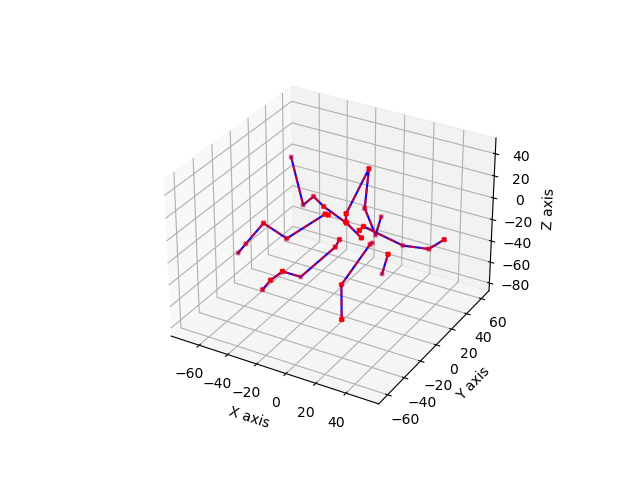

In [116]:
sample = 0
# print(image[sample])
prediction = (pred[sample].cpu()).numpy()
actual = (y[sample].cpu()).numpy()

visibility_mask = vis[sample]
mean = means_3d[:,2]
std = std_3d[:,2]

unnormalised_acc = (actual*std_3d)+means_3d
unnormalised_est = unnormalised_acc
unnormalised_est[:,2] = (prediction*std)+mean

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

plot_stick_bug(ax, unnormalised_acc, visibility_mask)
plot_stick_bug(ax, unnormalised_acc, visibility_mask, True)

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# use custom function to ensure equal axis proportions
set_axes_equal(ax)

# opens external plot
plt.show()